In [1]:
# Dependencies
import pandas as pd
from pathlib import Path
import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import holoviews as hv

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

### 1. Load and Clean Data
Import csv file into a DataFrame. Check for missing values, handle duplicates, convert data types, and address inconsistencies in the dataset.

In [2]:
data = Path("Resources/weather_energy_merged.csv") # import csv
df = pd.read_csv(data) # create dateframe
df.head()

,state,st_abb,date,tmin (f),tmax (f),tavg (f),ppt,coal,natural gas,petroleum coke,petroleum liquids
0,Alabama,AL,2001-01-01,29.1524,51.8234,40.4870,119.501,3076.0,210.654,0.0,46.240
1,Arkansas,AR,2001-01-01,26.6612,45.7412,36.2012,88.598,1320.0,77.895,0.0,30.192
2,Arizona,AZ,2001-01-01,28.2722,51.9206,40.0964,41.955,1773.0,194.994,0.0,36.448
3,California,CA,2001-01-01,31.7372,52.7198,42.2276,87.828,154.0,2879.145,94.0,85.000
4,Colorado,CO,2001-01-01,11.2748,37.4252,24.3500,25.485,1777.0,176.526,0.0,7.072


In [3]:
# combine petroleum into one category
df['petroleum'] = df['petroleum coke'] + df['petroleum liquids']

# Define columns for conversion and convert columns to appropriate type
datetime = ['date']
df[datetime] = df[datetime].apply(pd.to_datetime, errors='coerce')

# Extract useful features from the date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

numeric = ['tmin (f)', 'tmax (f)', 'tavg (f)', 'ppt', 'coal', 'natural gas', 'petroleum coke', 'petroleum liquids', 'petroleum', 'year', 'month']
df[numeric] = df[numeric].apply(pd.to_numeric, errors='coerce')

df = df.drop(['st_abb','petroleum coke', 'petroleum liquids'], axis=1).dropna().fillna(0) # drop unused columns, na, and fill null

# Define a Dictionary for Regions
regions = {"Maine": "Northeast", "New Hampshire": "Northeast", "Vermont": "Northeast", "Massachusetts": "Northeast", 
    "Rhode Island": "Northeast", "Connecticut": "Northeast", "New York": "Northeast", "Pennsylvania": "Northeast", 
    "New Jersey": "Northeast", "Ohio": "Midwest", "Indiana": "Midwest", "Illinois": "Midwest", "Michigan": "Midwest", 
    "Wisconsin": "Midwest", "Minnesota": "Midwest", "Iowa": "Midwest", "Missouri": "Midwest", "North Dakota": "Midwest", 
    "South Dakota": "Midwest", "Nebraska": "Midwest", "Kansas": "Midwest", "Delaware": "South", "Maryland": "South",
    "West Virginia": "South", "Virginia": "South", "Kentucky": "South", "Tennessee": "South", "North Carolina": "South", 
    "South Carolina": "South", "Georgia": "South", "Florida": "South", "Alabama": "South", "Mississippi": "South", 
    "Louisiana": "South", "Arkansas": "South", "Oklahoma": "South", "Texas": "South", "Montana": "West", "Idaho": "West", 
    "Wyoming": "West", "Colorado": "West", "New Mexico": "West", "Utah": "West", "Arizona": "West", "Nevada": "West", 
    "Washington": "West", "Oregon": "West", "California": "West", "Hawaii": "West", "Alaska": "West"}

# Map regions to the DataFrame
df['region'] = df['state'].map(regions)

# Define a mapping for months to seasons
seasons = {
    1: 'Winter', 2: 'Winter', 12: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

# Map seasons to the DataFrame
df['season'] = df['date'].dt.month.map(seasons)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13165 entries, 0 to 13247
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   state        13165 non-null  object        
 1   date         13165 non-null  datetime64[ns]
 2   tmin (f)     13165 non-null  float64       
 3   tmax (f)     13165 non-null  float64       
 4   tavg (f)     13165 non-null  float64       
 5   ppt          13165 non-null  float64       
 6   coal         13165 non-null  float64       
 7   natural gas  13165 non-null  float64       
 8   petroleum    13165 non-null  float64       
 9   year         13165 non-null  int32         
 10  month        13165 non-null  int32         
 11  region       13165 non-null  object        
 12  season       13165 non-null  object        
dtypes: datetime64[ns](1), float64(7), int32(2), object(3)
memory usage: 1.3+ MB


### 2. Exploratory Data Analysis (EDA)
Get an overview of the data and visualize distributions to gain familiarity with the different features.

Exploratory data analysis (EDA) indicates that coal constitutes 75% of total energy consumption, suggesting it will significantly influence clustering results. Regional differences show the Midwest and South have higher energy consumption than the Northeast and West. Monthly weather trends indicate that average temperature and precipitation increase in spring/summer and decrease in fall/winter, which may correlate with energy consumption patterns.

In [4]:
# Get a quick overview
df.describe()

,date,tmin (f),tmax (f),tavg (f),ppt,coal,natural gas,petroleum,year,month
count,13165,13165.000000,13165.000000,13165.000000,13165.000000,13165.000000,13165.000000,13165.000000,13165.000000,13165.000000
mean,2012-06-07 02:15:05.127231232,41.722737,63.748821,52.735783,83.134880,1436.970528,451.923030,23.065864,2011.975617,6.497607
min,2001-01-01 00:00:00,-12.434800,5.595800,-3.418600,0.002000,0.000000,0.000000,0.000000,2001.000000,1.000000
25%,2006-09-01 00:00:00,28.702400,49.575200,39.068600,40.868000,206.000000,50.760000,0.816000,2006.000000,3.000000
50%,2012-06-01 00:00:00,42.074600,65.831000,53.972600,76.690000,1130.000000,180.144000,2.992000,2012.000000,6.000000
75%,2018-03-01 00:00:00,55.889600,79.482200,67.613000,114.712000,2017.000000,466.344000,18.392000,2018.000000,9.000000
max,2023-12-01 00:00:00,76.020800,102.709400,88.862000,426.607000,10978.000000,8439.255000,1219.856000,2023.000000,12.000000
std,NaN,17.189091,18.482782,17.716736,54.049322,1526.811099,798.284987,70.103612,6.638854,3.452539


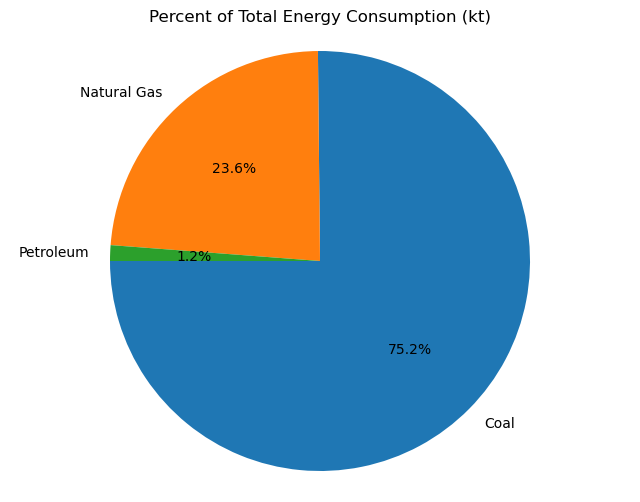

In [5]:
# Define the labels and values for the total energy consumption
labels = ['Coal', 'Natural Gas', 'Petroleum']
values = [df['coal'].mean(), df['natural gas'].mean(), df['petroleum'].mean()]

# Plot total energy consumption
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('Percent of Total Energy Consumption (kt)')
plt.axis('equal')
plt.show()

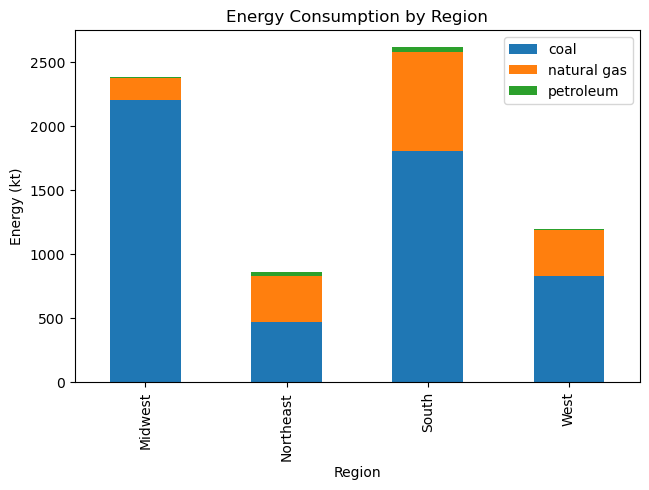

In [6]:
# Group by region and average the columns
region_df = df.groupby('region').mean(numeric_only=True).reset_index()

# Plot the Data by State
region_df.plot(x='region', y=['coal', 'natural gas', 'petroleum'], kind='bar', stacked=True)
plt.tight_layout()
plt.xlabel('Region')
plt.ylabel('Energy (kt)')
plt.title('Energy Consumption by Region')
plt.show()

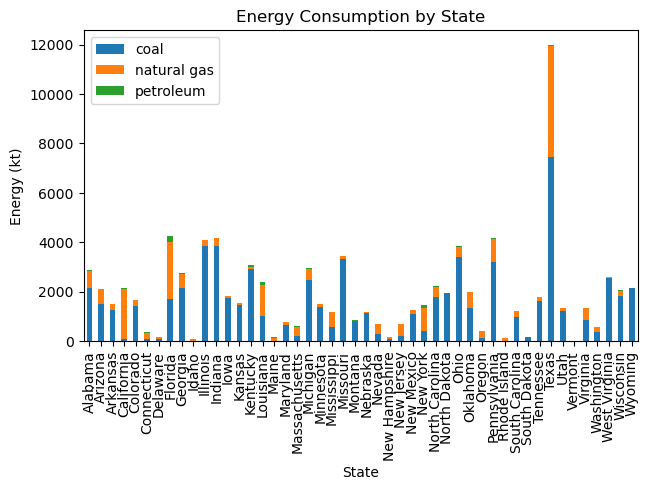

In [7]:
# Group by region and average the columns
region_df = df.groupby('state').mean(numeric_only=True).reset_index()

# Plot the Data by State
region_df.plot(x='state', y=['coal', 'natural gas', 'petroleum'], kind='bar', stacked=True)
plt.tight_layout()
plt.xlabel('State')
plt.ylabel('Energy (kt)')
plt.title('Energy Consumption by State')
plt.show()

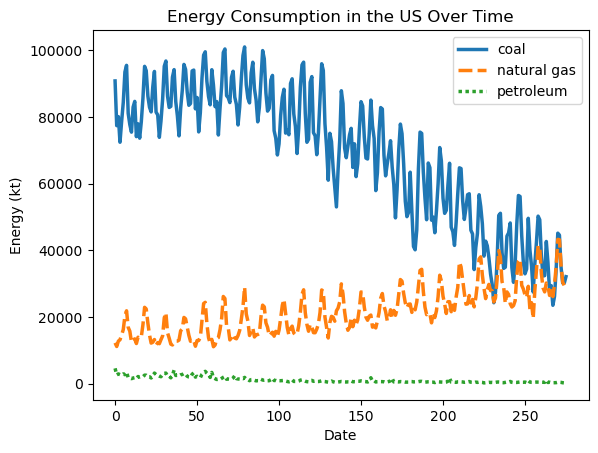

In [8]:
# Group by date and sum the columns
date_df = df.groupby('date').sum().reset_index()

# Plot the timeseries for energy consumption
sns.lineplot(data=date_df[['date', 'coal', 'natural gas', 'petroleum']], linewidth=2.5, palette="tab10")
plt.xlabel('Date')
plt.ylabel('Energy (kt)')
plt.title('Energy Consumption in the US Over Time')
plt.legend(loc='upper right')
plt.show()

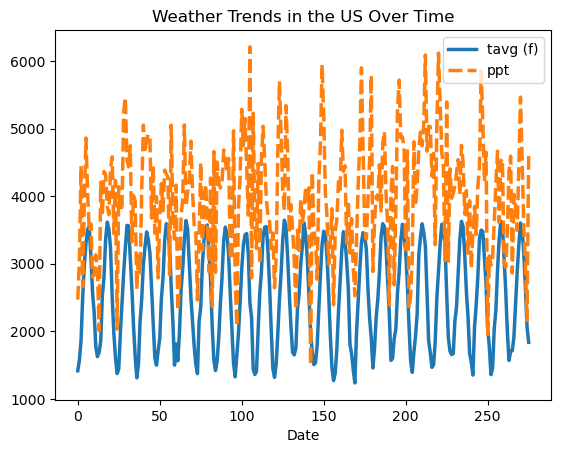

In [9]:
# Plot the timeseries for 
sns.lineplot(data=date_df[['tavg (f)', 'ppt']], linewidth=2.5, palette="tab10")
plt.xlabel('Date')
plt.title('Weather Trends in the US Over Time')
plt.legend(loc='upper right')
plt.show()

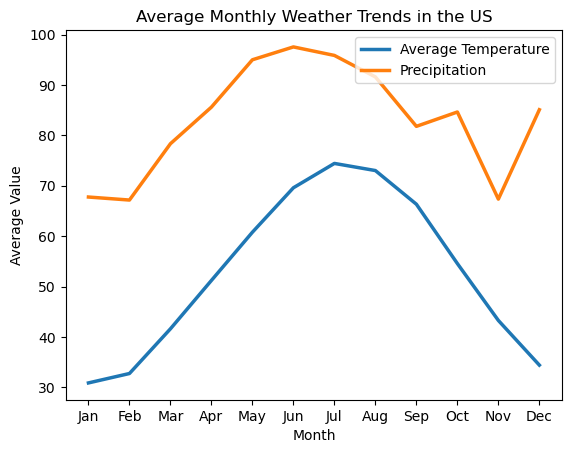

In [10]:
# Group by 'month' and calculate the mean for 'tavg' and 'ppt'
monthly_avg = df.groupby('month').agg({'tavg (f)': 'mean', 'ppt': 'mean'}).reset_index()

# Plot the timeseries for average temperature and precipitation
sns.lineplot(data=monthly_avg, x='month', y='tavg (f)', linewidth=2.5, label='Average Temperature', color='tab:blue')
sns.lineplot(data=monthly_avg, x='month', y='ppt', linewidth=2.5, label='Precipitation', color='tab:orange')

plt.xlabel('Month')
plt.ylabel('Average Value')
plt.title('Average Monthly Weather Trends in the US')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set month labels
plt.legend(loc='upper right')
plt.show()

### 3. Feature Engineering
Create new, or transforming existing, features to improve the dataset quality and relevance. Apply standard scaling to normalize the data and ensure all features contribute equally to the analysis or modeling.

Notes: Initially tried running models with the states one-hot encoded, but this was too much dimensionality where things like clustering became less effective. Then tried adding regions to be able to reflect location as a feature within the model and this works better, but still not optimally. Extracted month and year to create date feaures in the dataset and used Month as a basis for Random Forest timeseries prediction. This model was used to show why it is not optimal. Discovered the need to have combined energy consumption for predictibility because including those would lead to multicollinearity. This meant converting the units for each to be the same so they could be directly compared and combined. Considered adding numeric values for States and Regions, but this would cause the model to view them as continuous rather than categorical, which for states and regions this is not appropriate. Additionally, tried calculating the sine and cosine for month to capture cyclical patterns within the model, but this led to further decreased accuracy.

Numerical Features Used: tavg (average temperature), ppt (precipitation), month
Categorical Features Used (one-hot encoded): region_Midwest, region_Northeast, region_South, region_West

In [11]:
# Copy the dataframe
model_df = df.copy()

# Calculate total energy consumption
model_df['energy consumption'] = model_df['coal'] + model_df['natural gas'] + model_df['petroleum']

# Cyclical encoding for months
model_df['month_sin'] = np.sin(2 * np.pi * model_df['month'] / 12)
model_df['month_cos'] = np.cos(2 * np.pi * model_df['month'] / 12)

# Find the baseline year (earliest year)
baseline_year = model_df['year'].min()
# Create a new column for year difference
model_df['year_diff'] = model_df['year'] - baseline_year

# Transform categorical variables using get_dummies while keeping the original DataFrame
model_df = pd.get_dummies(model_df, columns=["state"], drop_first=False)
model_df = pd.get_dummies(model_df, columns=['season'], drop_first=False)
model_df = pd.get_dummies(model_df, columns=['region'], drop_first=False)

rfmodel_df = model_df.copy()

# Drop unneeded columns
model_df = model_df.drop(['date'], axis=1)
print(model_df.columns)

Index(['tmin (f)', 'tmax (f)', 'tavg (f)', 'ppt', 'coal', 'natural gas',
       'petroleum', 'year', 'month', 'energy consumption', 'month_sin',
       'month_cos', 'year_diff', 'state_Alabama', 'state_Arizona',
       'state_Arkansas', 'state_California', 'state_Colorado',
       'state_Connecticut', 'state_Delaware', 'state_Florida', 'state_Georgia',
       'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa',
       'state_Kansas', 'state_Kentucky', 'state_Louisiana', 'state_Maine',
       'state_Maryland', 'state_Massachusetts', 'state_Michigan',
       'state_Minnesota', 'state_Mississippi', 'state_Missouri',
       'state_Montana', 'state_Nebraska', 'state_Nevada',
       'state_New Hampshire', 'state_New Jersey', 'state_New Mexico',
       'state_New York', 'state_North Carolina', 'state_North Dakota',
       'state_Ohio', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania',
       'state_Rhode Island', 'state_South Carolina', 'state_South Dakota',
       'state_Ten

In [12]:
# Define the features and target
features = model_df[['tavg (f)', 'ppt', 'month', 'energy consumption', 'region_Midwest', 'region_Northeast', 'region_South', 'region_West']]
target = model_df['energy consumption']

### 4. Clustering (Elbow Method & KMeans)
Clustering reveals 3 clusters within the dataset. Box plots reveal that Cluster 1 has one outlier for average temperature, while precipitation shows multiple outliers across all clusters. Total energy consumption also has several outliers in Cluster 1.  Scatter plots for average temperature and precipitation reveal distinct groupings among clusters, with Cluster 2 appearing as a separate entity in both plots.

In [13]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(features)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Plot the DataFrame
rf_elbow = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k)
display(rf_elbow)

:Curve   [k]   (inertia)

In [14]:
# Define the model with cluster identified above
kmodel = KMeans(n_clusters=3, random_state=3)

# Fit the model
kmodel.fit(features)

# Make predictions
k_3 = kmodel.predict(features)

# Create a copy of the preprocessed data
kmeans_predictions_df = features.copy()

# Add a class column with the labels
kmeans_predictions_df['cluster'] = k_3
kmeans_predictions_df.head()

,tavg (f),ppt,month,energy consumption,region_Midwest,region_Northeast,region_South,region_West,cluster
0,40.4870,119.501,1,3332.894,False,False,True,False,1
1,36.2012,88.598,1,1428.087,False,False,True,False,0
2,40.0964,41.955,1,2004.442,False,False,False,True,0
3,42.2276,87.828,1,3212.145,False,False,False,True,1
4,24.3500,25.485,1,1960.598,False,False,False,True,0


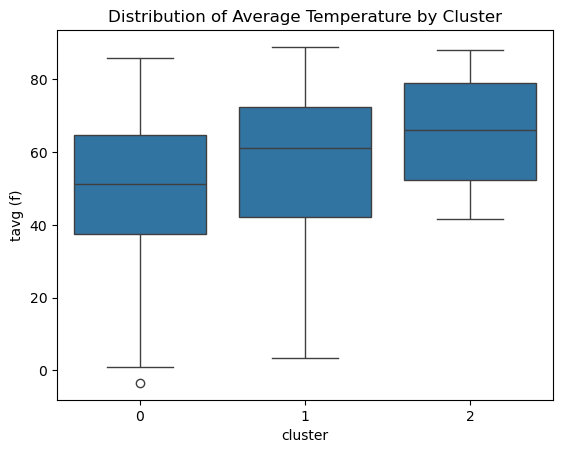

In [15]:
# Example: Boxplot for a specific feature across clusters
sns.boxplot(x='cluster', y='tavg (f)', data=kmeans_predictions_df)
plt.title('Distribution of Average Temperature by Cluster')
plt.show()

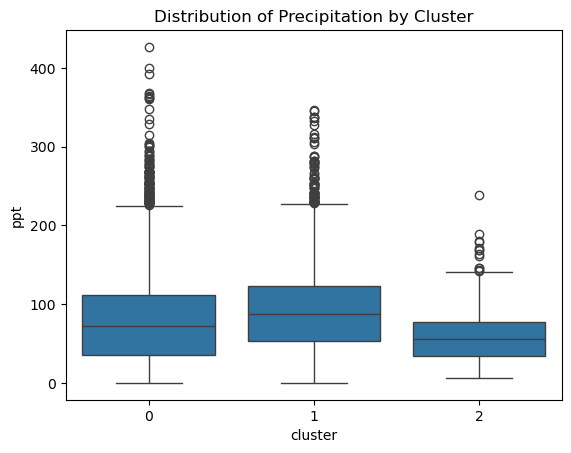

In [16]:
# Example: Boxplot for a specific feature across clusters
sns.boxplot(x='cluster', y='ppt', data=kmeans_predictions_df)
plt.title('Distribution of Precipitation by Cluster')
plt.show()

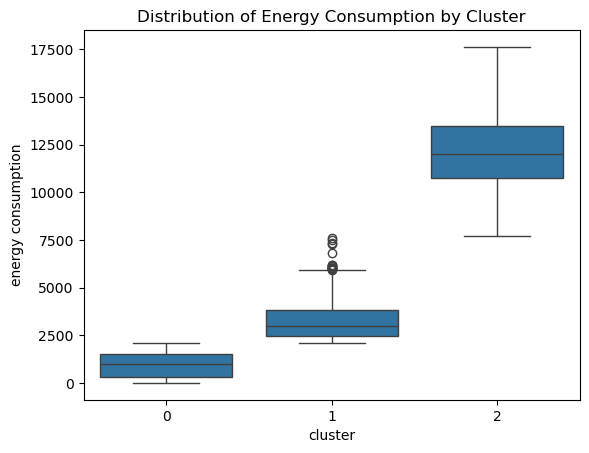

In [17]:
# Example: Boxplot for a specific feature across clusters
sns.boxplot(x='cluster', y='energy consumption', data=kmeans_predictions_df)
plt.title('Distribution of Energy Consumption by Cluster')
plt.show()

In [18]:
# Create scatter plots for clusters
rf_tavg_clusters = kmeans_predictions_df.hvplot.scatter(
    x="tavg (f)",
    y="energy consumption",
    by="cluster", 
    title="Scatter Plot of Clusters - k=3")
display(rf_tavg_clusters)

:NdOverlay   [cluster]
   :Scatter   [tavg (f)]   (energy consumption)

In [19]:
# Create scatter plots for clusters
rf_ppt_clusters = kmeans_predictions_df.hvplot.scatter(
    x="ppt",
    y="energy consumption",
    by="cluster",
    title = "Scatter Plot of Clusters - k=3")
display(rf_ppt_clusters)

:NdOverlay   [cluster]
   :Scatter   [ppt]   (energy consumption)

### 5. Linear Regression Model
A linear regression model confirms the clustering patterns, with significant coefficients indicating relationships between features and energy consumption.

Intercept: When both average temperature and precipitation are at zero, the predicted energy consumption is ~1151.53 kilotons.

Coefficients: For every unit increase in average temperature, the predicted energy consumption increases by approximately 25.3 kilotons, suggesting that as temperature increases, so does energy consumption (e.g. air conditioning in warmer months). For every unit increase in precipitation, the predicted energy consumption decreases by approximately 1.59 kilotons, which suggests that higher precipitation levels are associated with decreased energy consumption (e.g. no need for heating in rainy cooler weather).

In [20]:
# Prepare data for Linear Regression
X = features.copy()  # Create a copy of features
X.drop(['energy consumption'], axis=1, inplace=True)  # Drop the target variable
y = target

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Get the coefficients and intercept
coefficients = lin_reg.coef_
intercept = lin_reg.intercept_

# Print the coefficients
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 1151.5266290175043
Coefficients: [  18.88206118   -3.62209019   -9.80228139  644.64959358 -751.83042433
  772.91305525 -665.7322245 ]


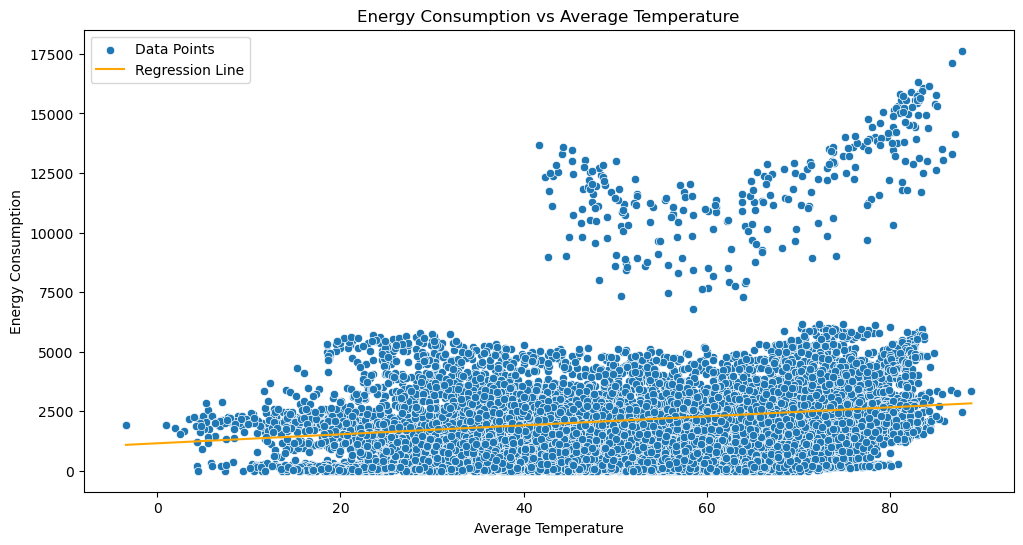

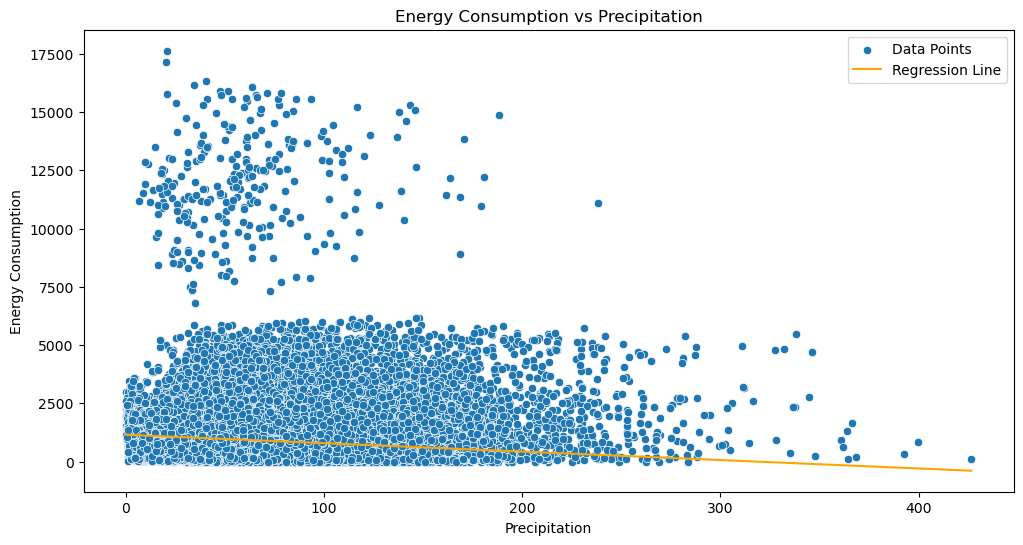

In [21]:
# Visualize the relationship for Average Temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(data=model_df, x='tavg (f)', y='energy consumption', label='Data Points')

# Create a range of values for tavg (f)
tavg_range = np.linspace(model_df['tavg (f)'].min(), model_df['tavg (f)'].max(), 100)
# Calculate predicted energy consumption for the range of tavg (f)
predicted_energy_consumption = intercept + coefficients[0] * tavg_range

plt.plot(tavg_range, predicted_energy_consumption, color='orange', label='Regression Line')
plt.title('Energy Consumption vs Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# Visualize the relationship for Precipitation
plt.figure(figsize=(12, 6))
sns.scatterplot(data=model_df, x='ppt', y='energy consumption', label='Data Points')

# Create a range of values for ppt
ppt_range = np.linspace(model_df['ppt'].min(), model_df['ppt'].max(), 100)
# Calculate predicted energy consumption for the range of ppt
predicted_energy_consumption = intercept + coefficients[1] * ppt_range

plt.plot(ppt_range, predicted_energy_consumption, color='orange', label='Regression Line')
plt.title('Energy Consumption vs Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

### 6. Feature importance and Prediction (Random Forest Model)
Random forest analysis shows average temperature and precipitation as the most important features.

In [22]:
# Prepare data for Random Forest (using all features except 'year')
X_rf = features.copy()
X_rf.drop(['energy consumption'], axis=1, inplace=True)
y_rf = target

# Split the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(random_state=42)

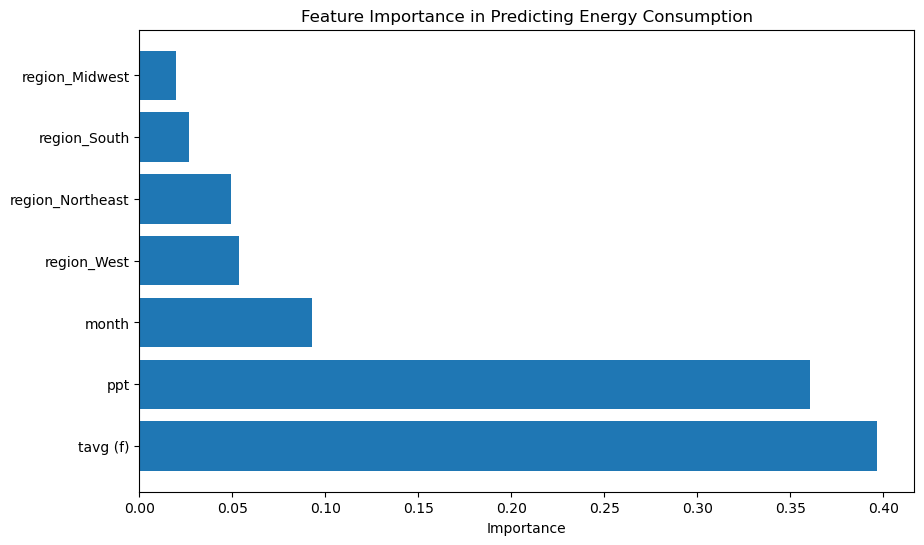

In [23]:
# Feature importance
importances = rf_model.feature_importances_
feature_names = X_rf.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Predicting Energy Consumption')
plt.show()

### 7. Model Evaluation & Prediction (Random Forest Model)
MSE of 3045606.44 suggests that, on average, the squared differences between predicted and actual energy consumption values are quite large, indicating a considerable amount of errors and may not be accurately predicting energy consumption. R² value of 0.26 means that only 26% of the variability in energy consumption can be explained by the features included in the model. The relatively high MSE and low R² suggest that the model may not be accurately capturing the relationship between the features and energy consumption and may not be the right fit for this type of analysis.

In [24]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_rf)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rf, y_pred_rf)
r2 = r2_score(y_test_rf, y_pred_rf)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 3045606.44
R-squared: 0.26


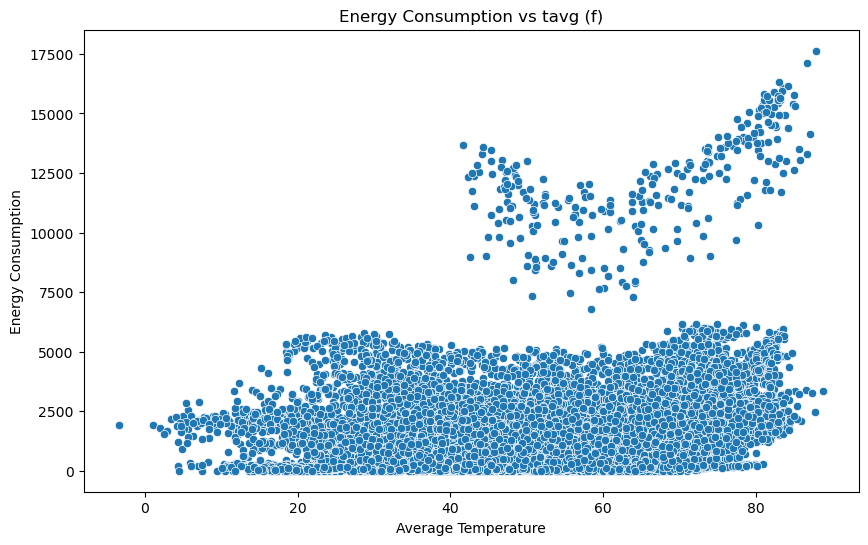

In [25]:
# Visualize the relationship between the most important feature and energy consumption
top_feature = importance_df['Feature'].iloc[0]  # Get the most important feature

plt.figure(figsize=(10, 6))
sns.scatterplot(data=model_df, x=top_feature, y='energy consumption')
plt.title(f'Energy Consumption vs {top_feature}')
plt.xlabel('Average Temperature')
plt.ylabel('Energy Consumption')
plt.show()

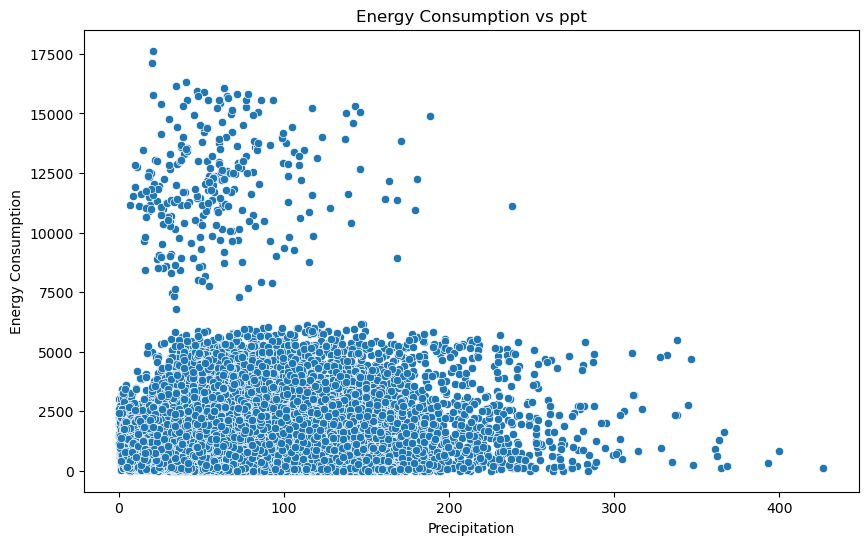

In [26]:
# Visualize the relationship between the second most important feature and energy consumption
top_feature = importance_df['Feature'].iloc[1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=model_df, x=top_feature, y='energy consumption')
plt.title(f'Energy Consumption vs {top_feature}')
plt.xlabel('Precipitation')
plt.ylabel('Energy Consumption')
plt.show()

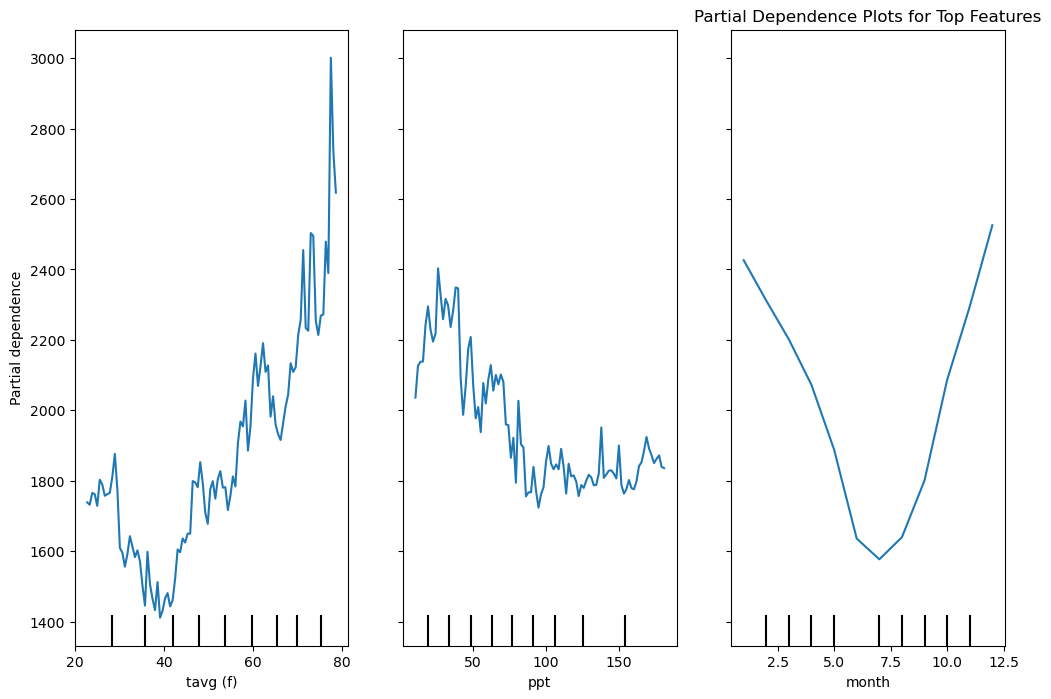

In [27]:
# Plot partial dependence for the top features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X_train_rf, features=importance_df['Feature'].head(3), ax=ax)
plt.title('Partial Dependence Plots for Top Features')
plt.show()

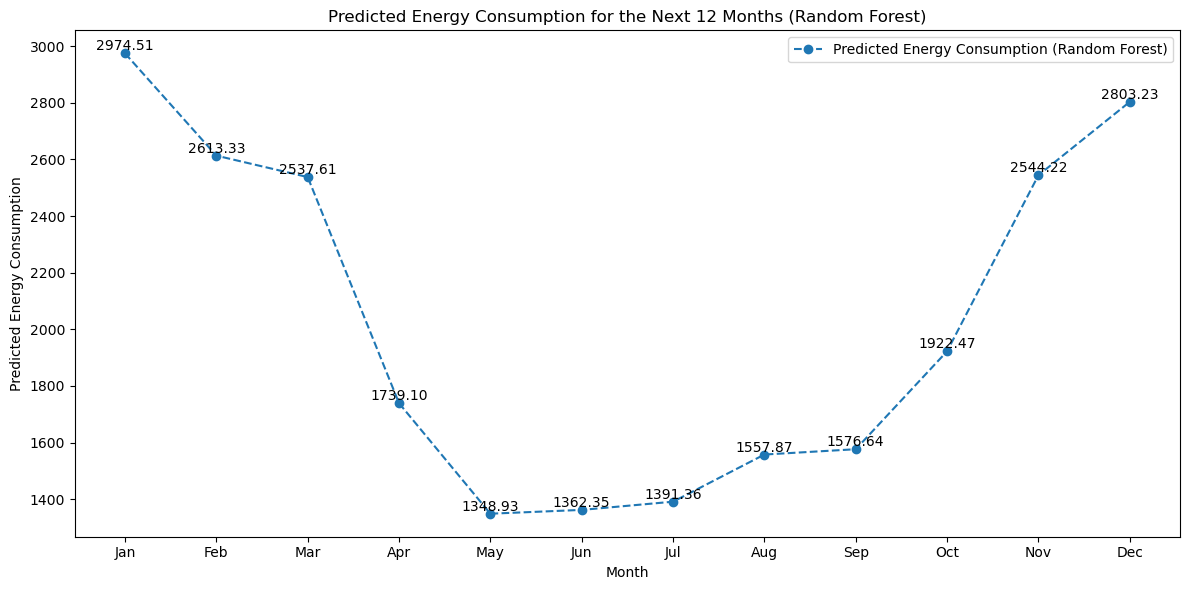

In [28]:
# Create a future dataset for the next 12 months (excluding 'year')
future_data = pd.DataFrame({
    'tavg (f)': [model_df['tavg (f)'].mean()] * 12,
    'ppt': [model_df['ppt'].mean()] * 12,
    #'month_sin': [model_df['month_sin'].mean()] * 12,
    #'month_cos': [model_df['month_cos'].mean()] * 12,
    #'year_diff': [model_df['year_diff'].mean()] * 12
    'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'region_Midwest': [model_df['region_Midwest'].mean()] * 12,
    'region_Northeast': [model_df['region_Northeast'].mean()] * 12,
    'region_South': [model_df['region_South'].mean()] * 12,
    'region_West': [model_df['region_West'].mean()] * 12,
    #'season_Fall': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    #'season_Spring': [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    #'season_Summer': [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    #'season_Winter': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
})

# Make predictions using Random Forest
predictions_rf = rf_model.predict(future_data)

# Plotting Random Forest Predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, 13), predictions_rf, label='Predicted Energy Consumption (Random Forest)', marker='o', linestyle='--')

# Adding data labels for each point
for i, value in enumerate(predictions_rf):
    plt.text(i + 1, value, f'{value:.2f}', ha='center', va='bottom')

plt.title('Predicted Energy Consumption for the Next 12 Months (Random Forest)')
plt.xlabel('Month')
plt.ylabel('Predicted Energy Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.tight_layout()
plt.savefig("Images/rf_predict.png")
plt.show()

### 8. Model Comparison
Comparison of Random Forest to the other models used for this project using the same variables: 'tmin (f)', 'tmax (f)', 'tavg (f)', 'coal', 'year', 'month', 'state_Texas'

In [29]:
# Prepare data for Random Forest
X_rf2 = rfmodel_df[['tmin (f)', 'tmax (f)', 'tavg (f)', 'year', 'month', 'state_Texas']]
y_rf2 = rfmodel_df['coal']

# Split the data
X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf2, y_rf2, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Set up the randomized search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Perform search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=4, cv=5, scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, random_state=42)

# Fit the randomized search
random_search.fit(X_train_rf2, y_train_rf2)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Evaluate the best model
best_rf_model_random = random_search.best_estimator_
y_pred_random = best_rf_model_random.predict(X_test_rf2)

# Calculate metrics for the best model
mae_random = mean_absolute_error(y_test_rf2, y_pred_random)
mse_random = mean_squared_error(y_test_rf2, y_pred_random)
r2_random = r2_score(y_test_rf2, y_pred_random)

print(f'Best Mean Absolute Error: {mae_random}')
print(f'Best Mean Squared Error: {mse_random}')
print(f'Best R^2 Score: {r2_random}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10}
Best Mean Absolute Error: 881.0436312320962
Best Mean Squared Error: 1282615.8793442915
Best R^2 Score: 0.46513223901464784


In [30]:
# Make Predictions for the Next Year
predicted_dates = pd.date_range(start=f"{rfmodel_df['year'].max() + 1}-01-01", periods=12, freq='ME')

future_data = pd.DataFrame({
    'tmin (f)': rfmodel_df['tmin (f)'].mean(),
    'tmax (f)': rfmodel_df['tmax (f)'].mean(),
    'tavg (f)': rfmodel_df['tavg (f)'].mean(),
    'year': rfmodel_df['year'].max() + 1,
    'month': range(1, 13),
    'state_Texas': 1
}, index=range(12))

predictions_rf = best_rf_model_random.predict(future_data)

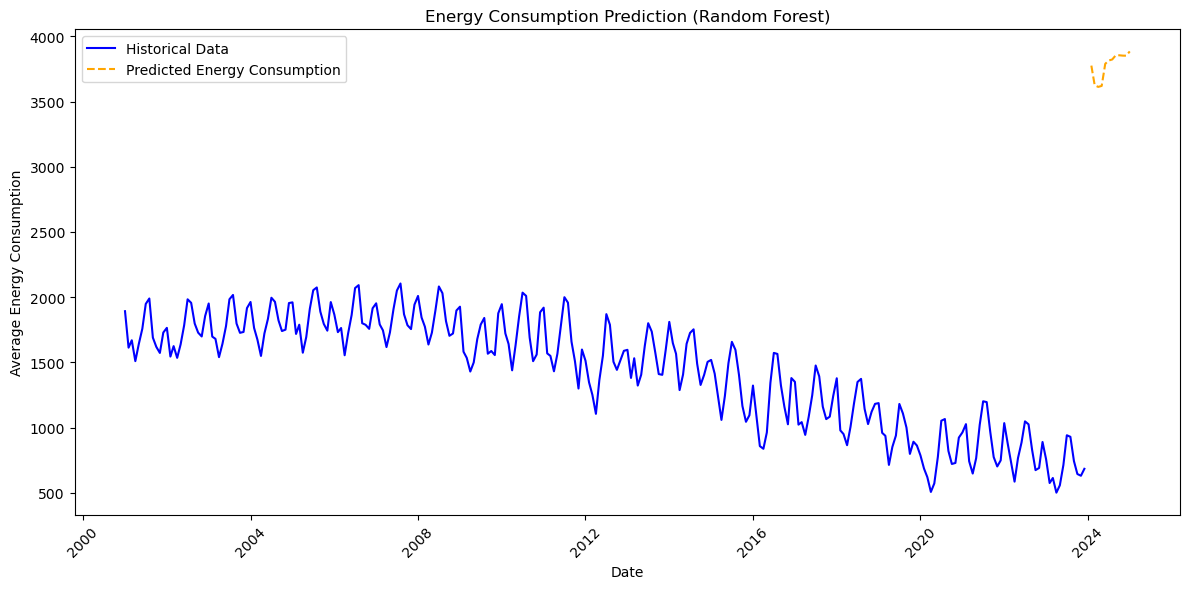

In [31]:
# Visualize the Results
historical_data = rfmodel_df.groupby('date')['coal'].mean().reset_index()
predicted_df = pd.DataFrame({'date': predicted_dates, 'coal': predictions_rf})

plt.figure(figsize=(12, 6))
plt.plot(historical_data['date'], historical_data['coal'], label='Historical Data', color='blue')
plt.plot(predicted_df['date'], predicted_df['coal'], label='Predicted Energy Consumption', linestyle='--', color='orange')

plt.title('Energy Consumption Prediction (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Average Energy Consumption')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("Images/rf_predict_compare.png")
plt.show()